<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/xor_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Using Graph Neural Networks
By Fayyaz Minhas.


This tutorial demonstrates how to model the XOR problem as a graph classification task using PyTorch Geometric. Each graph represents two binary inputs as nodes and the edges between them represent the input configuration. The goal is to classify the graphs according to the XOR operation:

* Input graph with nodes 0 and 1 and an edge connecting 0 to 0 -> Output: 0
* Input graph with nodes 0 and 1 and an edge connecting 0 to 1 -> Output: 1
* Input graph with nodes 0 and 1 and an edge connecting 1 to 0 -> Output: 1
* Input graph with nodes 0 and 1 and an edge connecting 1 to 1 -> Output: 0

We will use both EdgeConv and Graph attention layers.



In [4]:
!pip install torch-geometric
!pip install graphviz


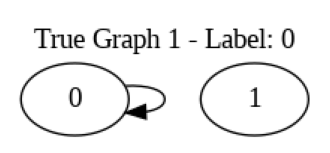

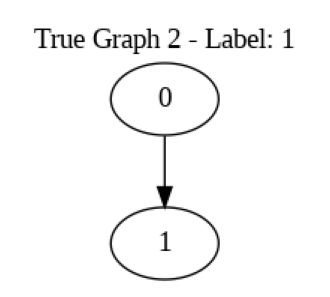

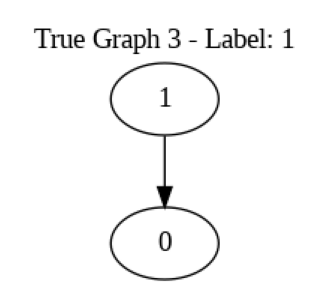

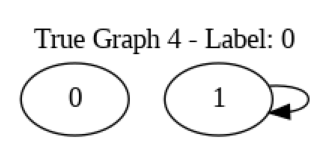

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import EdgeConv, global_mean_pool
import networkx as nx
from graphviz import Digraph
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

# Define the XOR dataset
class XORGraphDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.graphs = []
        self.labels = []

        # Add the four graphs and their labels
        self.add_graph([0, 1], [[0, 0]], 0)
        self.add_graph([0, 1], [[0, 1]], 1)
        self.add_graph([0, 1], [[1, 0]], 1)
        self.add_graph([0, 1], [[1, 1]], 0)

    def add_graph(self, nodes, edges, label):
        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
        x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)
        y = torch.tensor([label], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index, y=y)
        self.graphs.append(data)
        self.labels.append(label)

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

# Visualize graphs using NetworkX with directed edges and a compact layout
from graphviz import Digraph
def plotgraph(graphs, labels, title_prefix=''):
    for i, graph in enumerate(graphs):
        dot = Digraph(comment=f'{title_prefix} Graph {i+1}', engine='dot')
        x, edge_index = graph.x, graph.edge_index
        for node_id in range(x.shape[0]):
            dot.node(str(node_id), label=str(int(x[node_id].item())))
        for j in range(edge_index.shape[1]):
            src, dst = edge_index[0, j].item(), edge_index[1, j].item()
            dot.edge(str(src), str(dst))
        dot.attr(label=f'{title_prefix} Graph {i+1} - Label: {labels[i]}')
        dot.attr(labelloc='t')
        dot.render(f'{title_prefix}_graph_{i+1}', format='png', cleanup=True)
        plt.figure(figsize=(4, 4))
        img = plt.imread(f'{title_prefix}_graph_{i+1}.png')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

# Prepare the dataset and data loader
dataset = XORGraphDataset()
plotgraph(dataset.graphs, dataset.labels, "True")



/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 000, Loss: 0.7392
Epoch: 010, Loss: 0.6247
Epoch: 020, Loss: 0.3891
Epoch: 030, Loss: 0.1598
Epoch: 040, Loss: 0.0208
Epoch: 050, Loss: 0.0011
Epoch: 060, Loss: 0.0002
Epoch: 070, Loss: 0.0001
Epoch: 080, Loss: 0.0001
Epoch: 090, Loss: 0.0001
Epoch: 100, Loss: 0.0000
Epoch: 110, Loss: 0.0000
Epoch: 120, Loss: 0.0000
Epoch: 130, Loss: 0.0000
Epoch: 140, Loss: 0.0000
Epoch: 150, Loss: 0.0000
Epoch: 160, Loss: 0.0000
Epoch: 170, Loss: 0.0000
Epoch: 180, Loss: 0.0000
Epoch: 190, Loss: 0.0000
Epoch: 200, Loss: 0.0000
Epoch: 210, Loss: 0.0000
Epoch: 220, Loss: 0.0000
Epoch: 230, Loss: 0.0000
Epoch: 240, Loss: 0.0000
Epoch: 250, Loss: 0.0000
Epoch: 260, Loss: 0.0000
Epoch: 270, Loss: 0.0000
Epoch: 280, Loss: 0.0000
Epoch: 290, Loss: 0.0000
Epoch: 300, Loss: 0.0000
Epoch: 310, Loss: 0.0000
Epoch: 320, Loss: 0.0000
Epoch: 330, Loss: 0.0000
Epoch: 340, Loss: 0.0000
Epoch: 350, Loss: 0.0000
Epoch: 360, Loss: 0.0000
Epoch: 370, Loss: 0.0000
Epoch: 380, Loss: 0.0000
Epoch: 390, Loss: 0.0000


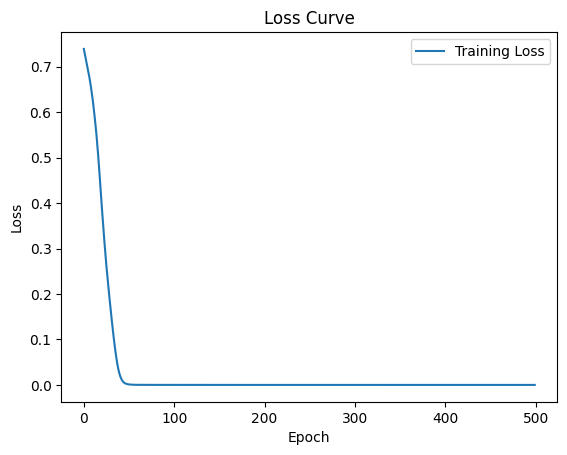

Accuracy: 1.0000
Graph 1 - Predicted label: 0
Graph 2 - Predicted label: 1
Graph 3 - Predicted label: 1
Graph 4 - Predicted label: 0


In [6]:

# Define the EdgeConv model
class EdgeNet(torch.nn.Module):
    def __init__(self):
        super(EdgeNet, self).__init__()
        self.conv1 = EdgeConv(torch.nn.Sequential(
            torch.nn.Linear(2, 16), torch.nn.ReLU(), torch.nn.Linear(16, 4)))
        self.conv2 = EdgeConv(torch.nn.Sequential(
            torch.nn.Linear(8, 16), torch.nn.ReLU(), torch.nn.Linear(16, 4)))
        self.fc = torch.nn.Linear(4, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with loss tracking
loss_values = []
model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')

# Plot the loss curve
plt.figure()
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Testing
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
accuracy = correct / len(loader.dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate responses on all 4 graphs
graphs = [
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 1]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 1]], dtype=torch.long).t().contiguous())
]

for i, graph in enumerate(graphs):
    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        print(f'Graph {i+1} - Predicted label: {pred.item()}')


Epoch: 000, Loss: 0.6976
Epoch: 010, Loss: 0.6909
Epoch: 020, Loss: 0.6843
Epoch: 030, Loss: 0.6672
Epoch: 040, Loss: 0.6263
Epoch: 050, Loss: 0.5448
Epoch: 060, Loss: 0.4092
Epoch: 070, Loss: 0.2452
Epoch: 080, Loss: 0.1165
Epoch: 090, Loss: 0.0497
Epoch: 100, Loss: 0.0227
Epoch: 110, Loss: 0.0123
Epoch: 120, Loss: 0.0079
Epoch: 130, Loss: 0.0056
Epoch: 140, Loss: 0.0043
Epoch: 150, Loss: 0.0035
Epoch: 160, Loss: 0.0029
Epoch: 170, Loss: 0.0025
Epoch: 180, Loss: 0.0022
Epoch: 190, Loss: 0.0019
Epoch: 200, Loss: 0.0017
Epoch: 210, Loss: 0.0015
Epoch: 220, Loss: 0.0014
Epoch: 230, Loss: 0.0012
Epoch: 240, Loss: 0.0011
Epoch: 250, Loss: 0.0010
Epoch: 260, Loss: 0.0009
Epoch: 270, Loss: 0.0009
Epoch: 280, Loss: 0.0008
Epoch: 290, Loss: 0.0007
Epoch: 300, Loss: 0.0007
Epoch: 310, Loss: 0.0006
Epoch: 320, Loss: 0.0006
Epoch: 330, Loss: 0.0006
Epoch: 340, Loss: 0.0005
Epoch: 350, Loss: 0.0005
Epoch: 360, Loss: 0.0005
Epoch: 370, Loss: 0.0004
Epoch: 380, Loss: 0.0004
Epoch: 390, Loss: 0.0004


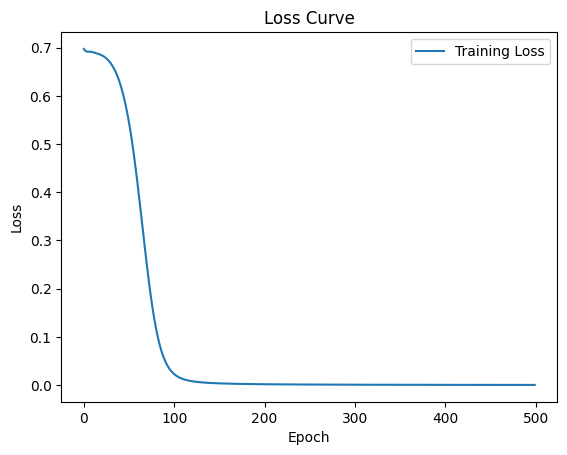

Accuracy: 1.0000
Graph 1 - Predicted label: 0
Graph 2 - Predicted label: 1
Graph 3 - Predicted label: 1
Graph 4 - Predicted label: 0


In [7]:
# Define the GAT model
from torch_geometric.nn import GATConv, global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(1, 4, heads=2)
        self.conv2 = GATConv(8, 4, heads=2)
        self.fc = torch.nn.Linear(8, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = global_mean_pool(x, data.batch)

        x = self.fc(x)

        return F.log_softmax(x, dim=1)

loader = DataLoader(dataset, batch_size=4, shuffle=True)
# Initialize model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop with loss tracking
loss_values = []
model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss.item():.4f}')
# Plot the loss curve
plt.figure()
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

# Testing
model.eval()
correct = 0
for data in loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
accuracy = correct / len(loader.dataset)
print(f'Accuracy: {accuracy:.4f}')

# Generate responses on all 4 graphs
graphs = [
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[0, 1]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 0]], dtype=torch.long).t().contiguous()),
    Data(x=torch.tensor([0, 1], dtype=torch.float).view(-1, 1), edge_index=torch.tensor([[1, 1]], dtype=torch.long).t().contiguous())
]

for i, graph in enumerate(graphs):
    graph = graph.to(device)
    with torch.no_grad():
        out = model(graph)
        pred = out.argmax(dim=1)
        print(f'Graph {i+1} - Predicted label: {pred.item()}')
